In [14]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy

In [15]:
import sys
sys.path.append("../filtering/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import example_systems

pendulum_system_gt = example_systems.double_pendulum

In [17]:
from helpers import vec

timesteps = np.arange(0.0, 3.0, step=pendulum_system_gt.delta_t)
T = len(timesteps)

states_gt = np.zeros((T, 6, 1))
controls = np.zeros((T, 1, 1))
measurements = np.zeros((T, 3, 1))

# initial position and velocity
states_gt[0] = vec(
    0,      # cart
    0,      # theta_1
    np.pi/2,    # theta_2
    0,      # cart_vel
    0,      # theta_1_vel
    0       # theta_2_vel
)

# cart acceleration schedule
controls[:] = vec(0.0)

w_test = np.zeros((6, 1))

for t in tqdm(range(1, T)):
# for t in range(1, T):
    x = states_gt[t-1]
    u = controls[t]

    x_next = pendulum_system_gt.query_dynamics_model(x, u, w_test)

    # # DEBUG
    # x_next = x_next.at[0].set(0)
    # x_next = x_next.at[1].set(0)
    # x_next = x_next.at[3].set(0)
    # x_next = x_next.at[4].set(0)

    states_gt[t] = x_next

    # print("theta_2:", x_next[4])

    z = pendulum_system_gt.query_measurement_model(x_next)
    measurements[t] = z


100%|██████████| 2999/2999 [00:36<00:00, 82.62it/s]


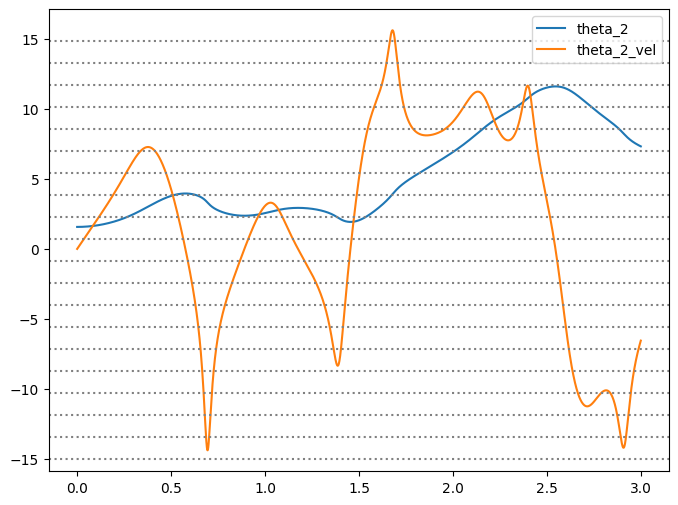

In [18]:
t_max = np.max(np.argwhere(~np.isnan(states_gt[:,4,0])))

if t_max < T-1:
    print("WARNING: System diverges at around t =", t_max)
    t_max -= 10

theta_2_gt = states_gt[:t_max,2,0]
theta_2_vel_gt = states_gt[:t_max,5,0]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(timesteps[:t_max], theta_2_gt, label="theta_2")
ax.plot(timesteps[:t_max], theta_2_vel_gt, label="theta_2_vel")
for y in np.arange(-15, 15, step=np.pi/2):
    ax.axhline(y, 0, timesteps[t_max], linestyle=":", color="gray")

ax.legend()

In [19]:
from matplotlib import animation

plt.rcParams["animation.html"] = "html5"

0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


0


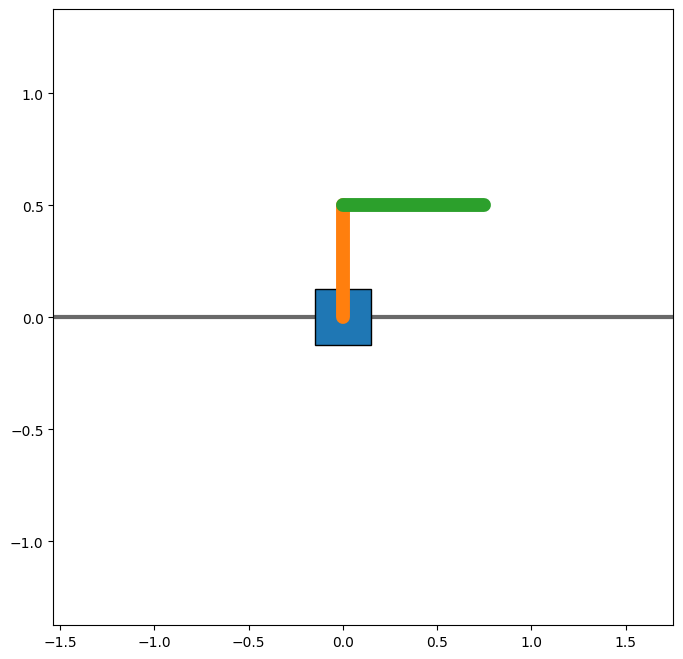

In [31]:
def visualize_pendulum(ax, cart, theta_1, theta_2, L1, L2):
    theta_1_frame = np.pi/2 - theta_1
    theta_2_frame = np.pi/2 - theta_2

    cart_pos = vec(cart, 0)
    link1_pos = cart_pos + vec(L1*np.cos(theta_1_frame), L1*np.sin(theta_1_frame))
    link2_pos = link1_pos + vec(L2*np.cos(theta_2_frame), L2*np.sin(theta_2_frame))

    ax.plot([cart_pos[0], link1_pos[0]], [cart_pos[1], link1_pos[1]], linewidth=10)
    ax.plot([link1_pos[0], link2_pos[0]], [link1_pos[1], link2_pos[1]], linewidth=10)
    ax.plot(*cart_pos, marker="x")



def animate_pendulum(fig, ax, carts, theta_1s, theta_2s, L1, L2):
    T = len(carts)

    # initialize scene
    ax.axhline(0, color="dimgray", linewidth=3)
    cart_marker = ax.plot(0, 0, marker="s", markersize=40, markeredgecolor="black", markerfacecolor="tab:blue")[0]
    link1_line = ax.plot([0, 0], [0, 0], linewidth=10, solid_capstyle="round")[0]
    link2_line = ax.plot([0, 0], [0, 0], linewidth=10, solid_capstyle="round")[0]

    # precompute cartesian coordinates
    theta_1s_frame = np.pi/2 - theta_1s     # convert angles to pyplot coordinate frame
    theta_2s_frame = np.pi/2 - theta_2s
    cart_pos = np.vstack([carts, np.zeros(T)]).T
    link1_pos = cart_pos + np.vstack([L1*np.cos(theta_1s_frame), L1*np.sin(theta_1s_frame)]).T
    link2_pos = link1_pos + np.vstack([L2*np.cos(theta_2s_frame), L2*np.sin(theta_2s_frame)]).T

    # set axis limits
    L = L1 + L2
    pad = 0.1 * L
    ax.set_xlim(np.min(cart_pos[:,0]) - L - pad, np.max(cart_pos[:,0]) + L + pad)
    ax.set_ylim(-L - pad, L + pad)

    def ani_func(t):
        if t % 10 == 0: print(t)

        link1_line.set_data([cart_pos[t,0], link1_pos[t,0]], [cart_pos[t,1], link1_pos[t,1]])
        link2_line.set_data([link1_pos[t,0], link2_pos[t,0]], [link1_pos[t,1], link2_pos[t,1]])
        cart_marker.set_data([cart_pos[t,0]], [cart_pos[t,1]])
    

    ani = animation.FuncAnimation(fig, ani_func, frames=T, interval=50)
    return ani


fig, ax = plt.subplots(figsize=(8, 8))
# visualize_pendulum(ax, 0.0, 0.2, 0.8, 0.5, 0.75)
states_subsampled = states_gt[::20]
ani = animate_pendulum(fig, ax, states_subsampled[:,0,0], states_subsampled[:,1,0], states_subsampled[:,2,0], 0.5, 0.75)
ani